**The data is scraped from Google Search News**

The data scraped consists of 2 main columns : **Link and Title**.
The goal is to cluster the news articles according to similarity of Title of the articles using kMeans.

In [ ]:
import json
import requests
from bs4 import BeautifulSoup
import csv

def get_news_data(start_page, end_page):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.54 Safari/537.36"
    }
    news_results = []
    index_counter = 0
    for page in range(start_page, end_page + 1):
        url = f"https://www.google.com/search?q=news&gl=us&tbm=nws&num=100&start={100 * (page - 1)}"
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, "html.parser")

        for el in soup.select("div.SoaBEf"):
            index_counter += 1
            news_results.append(
                {
                    "index": index_counter,
                    "link": el.find("a")["href"],
                    "title": el.select_one("div.MBeuO").get_text(),

                }
            )

    # Save to CSV file
    with open('/content/drive/MyDrive/Data Mining/news_data.csv', 'w', newline='', encoding='utf-8') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(['Index', 'Link', 'Title'])

        for article in news_results:
            csv_writer.writerow([article['index'], article['link'], article['title']])

    print(f"News data from page {start_page} to {end_page} has been saved to news_data.csv.")

start_page = 1
end_page = 15

get_news_data(start_page, end_page)


News data from page 1 to 15 has been saved to news_data.csv.


**Preprocessing**

In [1]:
import pandas as pd

df_news = pd.read_csv("/content/drive/MyDrive/Data Mining/news_data.csv", index_col='Index')


In [2]:
# Check for missing values
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 781 entries, 1 to 781
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Link    781 non-null    object
 1   Title   781 non-null    object
dtypes: object(2)
memory usage: 18.3+ KB


In [3]:
df_news.head()

,Link,Title
Index,,
1,https://www.defense.gov/News/News-Stories/Arti...,Strikes Against Iran-backed Militias Had 'Good...
2,https://www.nbcnews.com/news/weather/live-blog...,California flood warnings live updates: 3 dead...
3,https://www.sandiego.edu/news/detail.php?_focu...,Video: USD in the News Highlights for January ...
4,https://www.chinohills.org/CivicAlerts.aspx?AI...,News & Announcements • The City of Chino Hills...
5,https://www.uta.edu/news/news-releases/2024/02...,UTA experts to explore eclipse at Planetarium ...


**Tokenize, Lemmatize and drop stopwords using nltk**

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans


# Remove stopwords, tokenize, Lemmatization
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

df_news['Title'] = df_news['Title'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x.lower()) if word.isalpha() and word not in stop_words]))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
# Vectorize

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_news['Title'])

**Optimal Clusters**

To determine the optimal number of clusters, I used Elbow Method
Elbow Method is a technique that we use to determine the number of centroids(k) to use in a k-means clustering algorithm.  In this method to determine the k-value we continuously iterate for k=1 to k=n (Here n is the hyperparameter that we choose as per our requirement). For every value of k, we calculate the within-cluster sum of squares (WCSS) value.

WCSS - It is defined as the sum of square distances between the centroids and
each points.

From the graph, I will use 5 clusters as my optimum to start with.

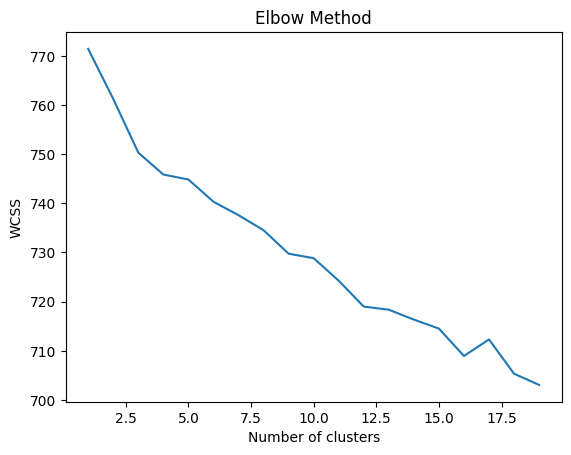

In [6]:
# Elbow Method to find optimal number of clusters
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # WCSS stands for 'Within-Cluster-Sum-of-Squares'
plt.show()

In [7]:
tfidf_matrix

<781x2360 sparse matrix of type '<class 'numpy.float64'>'
	with 5043 stored elements in Compressed Sparse Row format>

In [32]:
optimal_clusters = 5

# PCA for dimensionality reduction
pca = PCA(n_components=2)
tfidf_matrix_pca = pca.fit_transform(tfidf_matrix.toarray())

# K-Means Clustering
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)


**Model Prediction**

In [33]:
df_news['Cluster'] = kmeans.fit_predict(tfidf_matrix)

In [34]:
df_news.head()

,Link,Title,Cluster
Index,,,
1,https://www.defense.gov/News/News-Stories/Arti...,strike militia effect pentagon spokesman say,3
2,https://www.nbcnews.com/news/weather/live-blog...,california flood warning live update dead mill...,3
3,https://www.sandiego.edu/news/detail.php?_focu...,video usd news highlight january,4
4,https://www.chinohills.org/CivicAlerts.aspx?AI...,news announcement city chino hill spring r,0
5,https://www.uta.edu/news/news-releases/2024/02...,uta expert explore eclipse planetarium panel d...,3


**Model Evaluation**

To evaluate , I used silhoutte score.

The **silhouette score** measures how similar an object is to its own cluster compared to other clusters. The value ranges from -1 to 1, with a high value indicating good separation between clusters.




In [35]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(tfidf_matrix_pca, df_news['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.3736740239642491


**Silhouette Score:**

The silhouette score is 0.37, which indicates a moderate level of separation between clusters. A higher silhouette score is generally desirable.

Having a bit more data points and experimenting with different number of clusters/ or clustering methods might improve this.

**Model Evaluation with 3 Clusters**

In [36]:
optimal_clusters = 3

# PCA for dimensionality reduction
pca = PCA(n_components=2)
tfidf_matrix_pca = pca.fit_transform(tfidf_matrix.toarray())

# K-Means Clustering
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)

In [37]:
df_news['Cluster'] = kmeans.fit_predict(tfidf_matrix)
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(tfidf_matrix_pca, df_news['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.6459529685372984


With 3 clusters , The silhouette score is 0.646, which indicates a better level of separation between clusters. A higher silhouette score is generally desirable.

If changing the number of clusters from 5 to 3 results in an increase in the silhouette score from 0.37 to 0.6, it suggests that the data may be more naturally grouped into three clusters rather than five. This is a positive sign, as it indicates a better fit for the clustering algorithm.


In [ ]:
!pip install plotly

In [38]:
import plotly.express as px

# Assuming tfidf_matrix_pca is a NumPy array
# Convert the NumPy array to a DataFrame for Plotly Express
import pandas as pd
df_plotly = pd.DataFrame({
    'PC1': tfidf_matrix_pca[:, 0],
    'PC2': tfidf_matrix_pca[:, 1],
    'Cluster': df_news['Cluster'].astype(int).astype(str)  # Convert to integer and then to string
})

# Create scatterplot using Plotly Express
fig = px.scatter(df_plotly, x='PC1', y='PC2', color='Cluster', title='PCA Scatterplot of News Articles with Clusters',
                 labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2'},
                 category_orders={'Cluster': sorted(df_news['Cluster'].unique())},
                 size_max=10)

# Show the plot
fig.show()
